<a href="https://colab.research.google.com/github/chenny317/iat360_final/blob/main/NB_SVM_strong_linear_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

jigsaw_toxic_comment_classification_challenge_path = kagglehub.competition_download('jigsaw-toxic-comment-classification-challenge')

print('Data source import complete.')


Data source import complete.


## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naive bayes and bag of words matrices, I've made a preview available of one of fast.ai's upcoming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

In [3]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
subm = pd.read_csv('../sample_submission.csv')

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [7]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of the comments varies a lot.

In [9]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

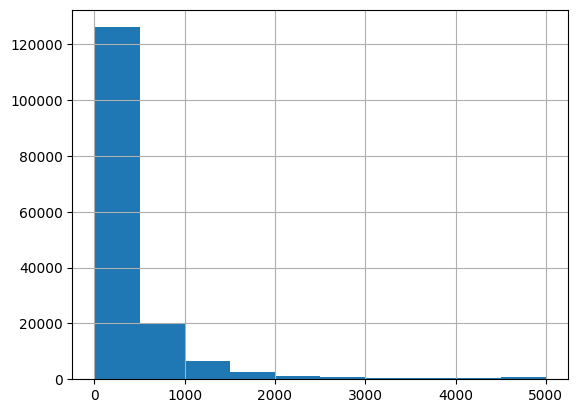

In [10]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
len(train),len(test)

(159571, 153164)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [13]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

<ipython-input-13-d2957acc749a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[COMMENT].fillna("unknown", inplace=True)


## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [14]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [15]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True, # Changed use_idf to True
               smooth_idf=True, sublinear_tf=True) # Changed smooth_idf and sublinear_tf to True
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [16]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

Here's the basic naive bayes feature equation:

In [18]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [19]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [20]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [21]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


And finally, create the submission file.

In [21]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

We import the standard Keras library

In [48]:
#!pip install tensorflow
#!pip install keras
#!pip install tensorflow-text # Install tensorflow-text for text preprocessing functionalities
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences from tensorflow.keras.preprocessing.sequence
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer from tensorflow.keras.preprocessing.text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

Movng on, as you can see from the sneak peek, the dependent variables are in the training set itself so we need to split them up, into X and Y sets.

In [24]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.



So this is what we are going to do:

1.   Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2.   Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3.   Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]





Fortunately, Keras has made our lives so much easier. If you are using the vanilla Tensorflow, you probably need to implement your own dictionary structure and handle the indexing yourself. In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences.

In [25]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.



In [26]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

In [27]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

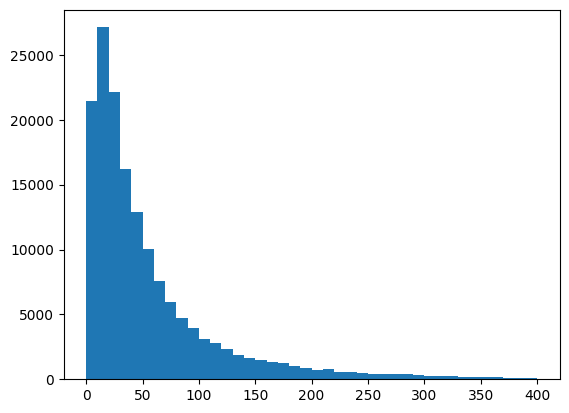

In [33]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. Then again, it sounds like something you could experiment and see what is the magic number.

the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.

By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [37]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context. Embedding is a pretty deep topic, and if you are interested, this is a comprehensive guide: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.

In [38]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

The embedding layer outputs a 3-D tensor of (None, 200, 128). Which is an array of sentence(None means that it's size is inferred), and for each words(200), there is an array of 128 coordinates in the vector space of embedding.

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

In [39]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

As you can see from other Kaggle kernels, different variants (Average,Max,etc) of pooling layers are used for dimensionality reduction and they could yield different results so do try them out.



In [42]:
x = GlobalMaxPool1D()(x)

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

We set the dropout layer to drop out 10%(0.1) of the nodes.

In [43]:
x = Dropout(0.1)(x)

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

Activation( (Input X Weights) + Bias)

all in 1 line, with the weights, bias and activation layer all set up for you! We have defined the Dense layer to produce a output dimension of 50.

In [44]:
x = Dense(50, activation="relu")(x)

We feed the output into a Dropout layer again.

In [45]:
x = Dropout(0.1)(x)

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

In [46]:
x = Dense(6, activation="sigmoid")(x)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

In [49]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

The moment that we have been waiting for as arrived! It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).

In [50]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.8462 - loss: 0.1057 - val_accuracy: 0.9940 - val_loss: 0.0495
Epoch 2/2
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9853 - loss: 0.0458 - val_accuracy: 0.9939 - val_loss: 0.0471
